In [65]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


In [66]:
eth_data = yf.download("ETH-USD", period="max", interval="1d")
print(eth_data.tail())

[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open       Volume
Ticker          ETH-USD      ETH-USD      ETH-USD      ETH-USD      ETH-USD
Date                                                                       
2025-05-19  2529.166748  2545.461182  2353.427002  2498.800049  27351331811
2025-05-20  2524.173096  2585.619873  2446.446777  2529.135010  23453322578
2025-05-21  2552.347168  2614.060791  2454.537842  2524.159180  31952904125
2025-05-22  2664.156982  2691.102295  2546.434814  2552.766846  26596978352
2025-05-23  2659.612305  2727.053223  2647.708008  2664.704590  28017956864


In [67]:
prices = eth_data['Close'].values.reshape(-1, 1)

In [68]:
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

In [69]:
def create_dataset(data, time_steps=7):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 7
X, y = create_dataset(prices_scaled, time_steps)

In [70]:
split = int(len(X) * 0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [71]:
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (2471, 7, 1), Test shape: (275, 7, 1)


In [72]:
model = Sequential()
model.add(LSTM(50, input_shape=(time_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [73]:
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0285 - val_loss: 0.0015
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.2373e-04 - val_loss: 0.0016
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6296e-04 - val_loss: 0.0018
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.0046e-04 - val_loss: 0.0015
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.6840e-04 - val_loss: 0.0012
Epoch 6/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.0834e-04 - val_loss: 0.0014
Epoch 7/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.4410e-04 - val_loss: 0.0011
Epoch 8/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.3522e-04 - val_loss: 0.0010
Epoch 9/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.4552e-04 - val_loss: 0.0010
Epoch 10/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.1785e-04 - val_loss: 0.0014
Epoch 11/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.9527e-04 - val_loss: 9.0234e-

In [74]:
last_seq = prices_scaled[-time_steps:]
input_seq = last_seq.reshape(1, time_steps, 1)

preds = []
for _ in range(2):
    pred = model.predict(input_seq)[0, 0]
    preds.append(pred)
    input_seq = np.append(input_seq[:, 1:, :], [[[pred]]], axis=1)

predicted_prices = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

print(f"Predicted ETH closing prices for next 2 days:")
print(f"Day 1: {predicted_prices[0,0]:.2f} USD")
print(f"Day 2: {predicted_prices[1,0]:.2f} USD")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted ETH closing prices for next 2 days:
Day 1: 2638.63 USD
Day 2: 2619.49 USD


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


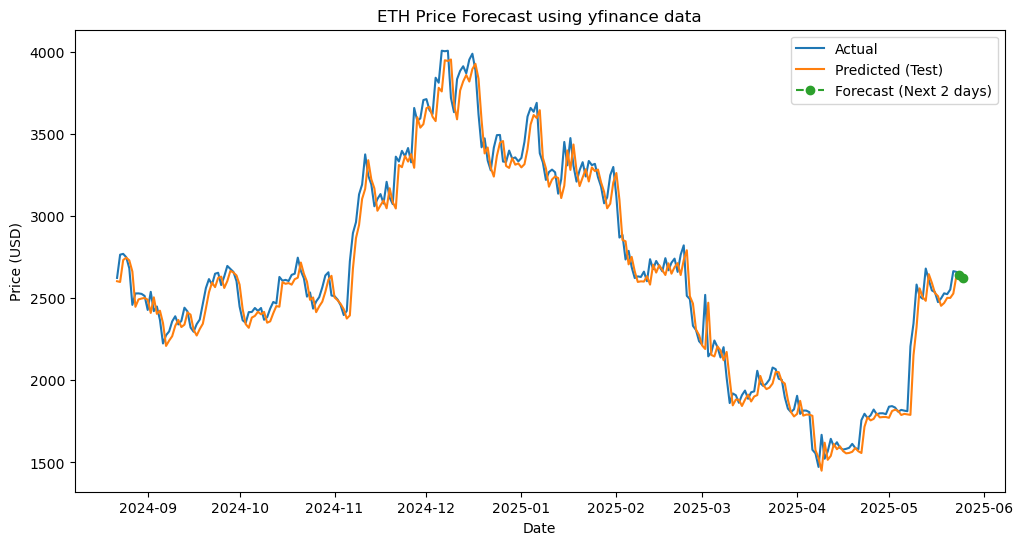

In [75]:
y_pred_test = model.predict(X_test)
y_pred_test_rescaled = scaler.inverse_transform(y_pred_test)
y_test_rescaled = scaler.inverse_transform(y_test)

plt.figure(figsize=(12,6))
plt.plot(eth_data.index[-len(y_test):], y_test_rescaled, label='Actual')
plt.plot(eth_data.index[-len(y_test):], y_pred_test_rescaled, label='Predicted (Test)')

forecast_dates = pd.date_range(start=eth_data.index[-1] + pd.Timedelta(days=1), periods=2)
plt.plot(forecast_dates, predicted_prices, marker='o', linestyle='--', label='Forecast (Next 2 days)')

plt.title('ETH Price Forecast using yfinance data')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed

Total data length: 2753
Data for May 2025:
Price             Close         High          Low         Open       Volume
Ticker          ETH-USD      ETH-USD      ETH-USD      ETH-USD      ETH-USD
Date                                                                       
2025-05-01  1839.221558  1872.939575  1793.151123  1794.041016  15861442721
2025-05-02  1842.707886  1869.530029  1814.730469  1839.174805  13570171872
2025-05-03  1833.839722  1848.246826  1812.815674  1842.718140   8344452620
2025-05-04  1808.594238  1849.998535  1804.495117  1833.647217   8918979887
2025-05-05  1819.697510  1832.050781  1783.314819  1808.704956  11389336489
2025-05-06  1815.087524  1820.796631  1753.315430  1819.734009  13206516310
2025-05-07  1811.606689  1849.658447  1788.687378  1815.018921  50540755039
2025-05-08  2206.514648  2222.205566  1809.456909  1811.546387  37777245241
2025-05-09  2345.507324  2486.006836  2186.054443  2206.128174  43766026875
2025-05-10  2582.422607  2597.543457  2320.23


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 0.9379 - val_loss: 1.0015
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6476 - val_loss: 0.7872
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6663 - val_loss: 0.5944
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.4758 - val_loss: 0.4295
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3785 - val_loss: 0.2852
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2529 - val_loss: 0.1663
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1999 - val_loss: 0.0757
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1506 - val_loss: 0.0214
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0734 - val_loss: 0.0082
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0873 - val_loss: 0.0294
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0787 - val_loss: 0.0588
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0795 - val_loss: 0.0666
Epoch 13/50

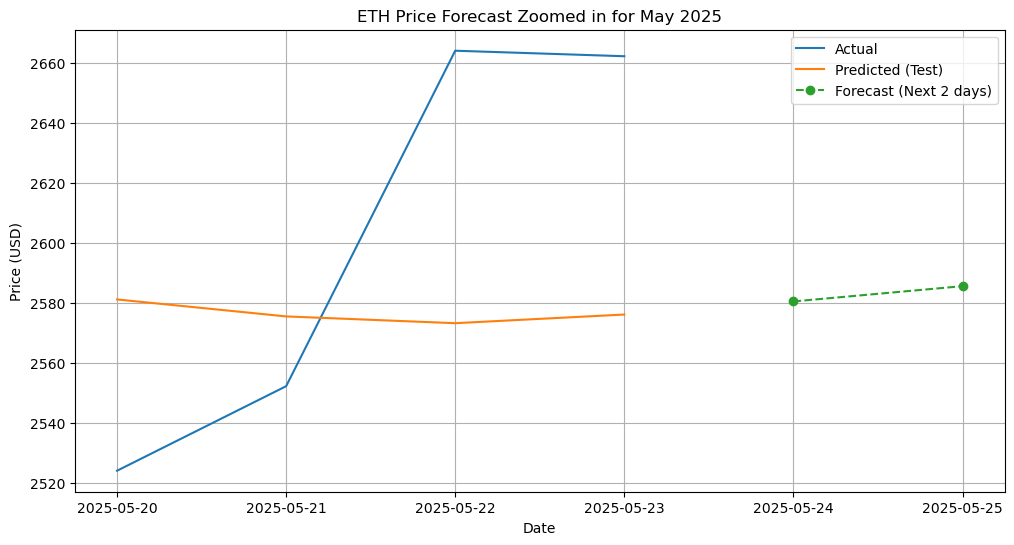

In [76]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# 1. Download full ETH daily data
eth_data = yf.download("ETH-USD", period="max", interval="1d")
print(f"Total data length: {len(eth_data)}")

# 2. Filter data for May 2025 only
start_date = "2025-05-01"
end_date = "2025-05-31"
eth_may2025 = eth_data.loc[start_date:end_date].copy()

print(f"Data for May 2025:\n{eth_may2025}")

# If there is not enough data in May 2025 (like less than 10 days), 
# you might want to extend date range or adjust strategy

prices = eth_may2025['Close'].values.reshape(-1, 1)

# 3. Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

# 4. Create sequences (using past 7 days to predict next day)
def create_dataset(data, time_steps=7):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 7
X, y = create_dataset(prices_scaled, time_steps)

# 5. Train/test split (use 80% for train, 20% test due to small sample)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# 6. Build model
model = Sequential()
model.add(LSTM(50, input_shape=(time_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 7. Train model
model.fit(X_train, y_train, epochs=50, batch_size=4, validation_data=(X_test, y_test))

# 8. Predict next 2 days
last_seq = prices_scaled[-time_steps:]
input_seq = last_seq.reshape(1, time_steps, 1)

preds = []
for _ in range(2):
    pred = model.predict(input_seq)[0, 0]
    preds.append(pred)
    input_seq = np.append(input_seq[:, 1:, :], [[[pred]]], axis=1)

predicted_prices = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

print(f"Predicted ETH closing prices for next 2 days after May 2025:")
print(f"Day 1: {predicted_prices[0, 0]:.2f} USD")
print(f"Day 2: {predicted_prices[1, 0]:.2f} USD")

# 9. Plot May 2025 actual vs predicted + forecast
y_pred_test = model.predict(X_test)
y_pred_test_rescaled = scaler.inverse_transform(y_pred_test)
y_test_rescaled = scaler.inverse_transform(y_test)

plt.figure(figsize=(12,6))
plt.plot(eth_may2025.index[-len(y_test):], y_test_rescaled, label='Actual')
plt.plot(eth_may2025.index[-len(y_test):], y_pred_test_rescaled, label='Predicted (Test)')

forecast_dates = pd.date_range(start=eth_may2025.index[-1] + pd.Timedelta(days=1), periods=2)
plt.plot(forecast_dates, predicted_prices, marker='o', linestyle='--', label='Forecast (Next 2 days)')
plt.title('ETH Price Forecast Zoomed in for May 2025')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()
